# Tutorial 02: Baselines and Trajectory Diagnostics

**Author:** Ming Jin | [jinming.tech](https://jinming.tech) | jinming@vt.edu  
**Series:** Safe RL for Power and Energy Systems | [Full References](https://github.com/jinming99/GridGuardian-RL/blob/main/REFERENCES.md)

This notebook runs baseline controllers (Greedy, Random, MPC, Offline Optimal) and introduces trajectory-level diagnostics to understand optimality gaps, constraint binding, and where to improve policies.

### Objectives

- Run and compare baseline controllers
- Visualize charging schedules and constraint usage
- Introduce trajectory debugging:
  - Constraint slack inspection and binding times
  - Action critique at critical states via one-step MPC
  - Immediate reward/cost deltas for counterfactual actions
  - Critical state ranking (e.g., high MOER × high demand, tight network capacity)


## Section 1: Setup and Data Understanding

### 1.1 Dependencies and Core Imports

In [1]:
import sys
from pathlib import Path

try:
    nb_dir = Path(__file__).parent
except NameError:
    nb_dir = Path.cwd()

repo_root = nb_dir.parent  # tutorials/ -> repo root
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact, widgets, interactive_output
import warnings
import os
import copy
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Notebook helpers for compact prints and plots
from tutorials.utils import quick_plot, show, show_metrics

In [2]:
# Core environment and baselines
from envs.evcharging import EVChargingEnv, GMMsTraceGenerator, RealTraceGenerator, MultiAgentEVChargingEnv
from envs.evcharging.env import magnitude_constraint
from tutorials.utils import GreedyAlgorithm, RandomAlgorithm, MPC, OfflineOptimal

# Data loading
from data.load_moer import load_monthly_moer, MOERLoader
from envs.evcharging.utils import get_real_events, to_la_dt

# Import utility functions
from tutorials.utils import (
    save_timeseries, load_timeseries,
    save_df_gz, load_df_gz,
    get_cache_dir, ensure_dir,
    evaluate_policy, sweep_noise,
    plot_robustness_heatmap, plot_action_saturation,
    plot_action_distribution, plot_actions_heatmap,
    plot_cost_return_pareto, plot_violation_heatmap,
    plot_training_curves,
    find_critical_windows_from_series,
    save_evaluation_results, load_evaluation_results,
    run_scenario_sweep, plot_algorithm_comparison_matrix,
    run_multiagent_scenario_sweep, collect_ma_trajectory, plot_agent_coordination_matrix
)

from tutorials.utils import (
    pilot_signals_df,
    constraint_slack_t,
    constraint_slack_series,
    plot_slack_from_env,
    algorithm_arena,
    interactive_critical_timeline,
    reconstruct_state,
    rollout_to_trajectory,
    traj_to_timeseries_df,
    standardize_trajectory_costs,
    collect_trajectory_direct,
    # Planning-friendly wrappers and composer
    apply_wrappers,
    DepartureUncertaintyWrapper, GrowingForecastErrorWrapper, CarbonEmphasisWrapper, DemandChargeWrapper,
)

import cvxpy as cp
import acnportal.acnsim as acns
from tutorials.utils import wrap_policy, create_ev_env, PlanningEvalConfig, get_planning_eval_env_fn


# Global density toggle for tutorial demos
# This tutorial enables a denser, more demonstrable scenario when using the shared
# environment factory `create_ev_env()` by passing `dense_mode=True` (default 3x sessions).
# This improves interactivity and reduces flat segments during short horizons.
# For realistic benchmarking and research experiments, set `TUTORIAL_DENSE = False`.
TUTORIAL_DENSE = True

### 1.2 Solver Configuration



In [3]:
def solve_with_fallback(prob):
    """Solve CVXPY problem using a robust fallback across installed solvers.

    Rationale: not all environments have commercial solvers (e.g., MOSEK).
    This wrapper tries multiple solvers in order of preference so the
    notebooks run everywhere. Solver choice may affect speed but should not
    affect correctness.
    """
    from tutorials.utils import solve_cvx_with_fallback
    return solve_cvx_with_fallback(prob)

show("section: Available solvers")
show("text: {solvers}", solvers=cp.installed_solvers())

['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


### 1.3 Data Inspection

Let's examine our three data sources: MOER (carbon intensity), real EV sessions, and synthetic GMM sessions.
MOER shows daily patterns (low at night, high during day), and charging sessions cluster around work hours - 
these patterns directly impact optimal charging strategies.

#### MOER Data

**MOER (Marginal Operating Emissions Rate)** represents the carbon intensity of electricity at each 5-minute interval. Lower MOER means cleaner energy. The forecasts (f1, f6, f12, etc.) allow algorithms to plan ahead.

,moer,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36
time,,,,,,,,,,,,,,,,,,,,,
2019-05-31 00:00:00+00:00,0.121442,0.143301,0.140829,0.138640,0.136275,0.137925,0.145098,0.155275,0.169213,0.165420,...,0.191443,0.200999,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264
2019-05-31 00:05:00+00:00,0.121442,0.123767,0.128867,0.130003,0.124601,0.137613,0.155275,0.169213,0.165420,0.162794,...,0.200999,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264,0.213462
2019-05-31 00:10:00+00:00,0.122233,0.120110,0.121420,0.117840,0.128653,0.138215,0.169213,0.165420,0.162794,0.151170,...,0.204948,0.210293,0.222099,0.234960,0.233212,0.220456,0.214562,0.220264,0.213462,0.209941


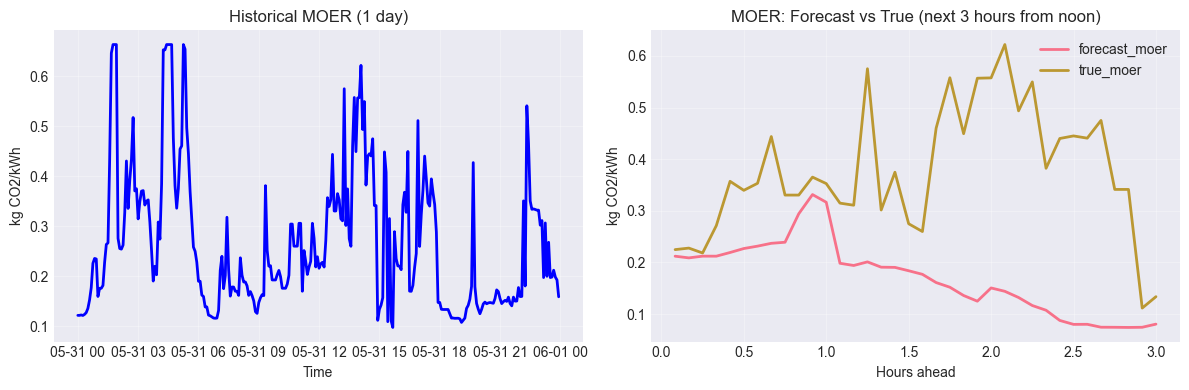

In [4]:
# MOER (historical + forecasts)
df_moer = load_monthly_moer(2019, 6, ba='SGIP_CAISO_SCE')
show("section: MOER Data Structure")
show_metrics({'Columns': list(df_moer.columns)[:10], 'Shape': df_moer.shape, 'Date Range': f"{df_moer.index[0]} to {df_moer.index[-1]}"})
show("table", df=df_moer.head(3))

# Visualize MOER pattern
ref_idx = 144  # noon sample
# Build overlay for the next available forecast horizon (36 steps = 3 hours)
h = np.arange(1, 37)
hours_ahead = h * (5.0 / 60.0)
forecast_cols = [f"f{i}" for i in h]
try:
    true_future = df_moer['moer'].values[ref_idx+1: ref_idx+1+36]
    forecast_future = df_moer[forecast_cols].iloc[ref_idx].values
    L = int(min(len(true_future), len(forecast_future), len(hours_ahead)))
    overlay_df = pd.DataFrame({
        'hours_ahead': hours_ahead[:L],
        'true_moer': np.asarray(true_future[:L], dtype=float),
        'forecast_moer': np.asarray(forecast_future[:L], dtype=float),
    })
    overlay_long = overlay_df.melt(id_vars='hours_ahead', value_vars=['true_moer','forecast_moer'],
                                   var_name='series', value_name='moer')
except Exception:
    # Fallback if forecasts are missing: empty overlay
    overlay_long = pd.DataFrame({'hours_ahead': [], 'moer': [], 'series': []})

quick_plot({
    'layout': '1x2', 'size': (12, 4), 'sharex': False,
    'plots': [
        {
            'type': 'line', 'x': 'time', 'y': 'moer_day',
            'title': 'Historical MOER (1 day)', 'xlabel': 'Time', 'ylabel': 'kg CO2/kWh'
        },
        {
            'type': 'line', 'data': 'overlay_long', 'x': 'hours_ahead', 'y': 'moer', 'group': 'series',
            'title': 'MOER: Forecast vs True (next 3 hours from noon)',
            'xlabel': 'Hours ahead', 'ylabel': 'kg CO2/kWh', 'legend': True
        }
    ]
}, {
    'time': df_moer.index[:288],
    'moer_day': df_moer['moer'].values[:288],
    'overlay_long': overlay_long
})

#### Real Events

**What we're seeing:** Real charging sessions from Caltech's ACN dataset. The 'claimed' flag indicates sessions with known departure times, which are easier to schedule optimally.


In [5]:
# Real events (ACN-Data packaged)
start, end = to_la_dt('2019-05-01'), to_la_dt('2019-08-31')
events_df = get_real_events(start, end, site='caltech')
show("section: Real Events Data Structure")
show_metrics({
    'Columns': list(events_df.columns),
    'Total sessions': len(events_df),
    'Avg requested energy (kWh)': f"{events_df['requested_energy (kWh)'].mean():.2f}",
})

#### GMM-Generated Events

**Purpose:** The GMM (Gaussian Mixture Model) generates synthetic charging sessions that statistically match real patterns. This allows unlimited experimentation without privacy concerns.

In [6]:
# GMM-sampled events (synthetic) — preview with regular generator (not necessarily dense)
gmm_gen = GMMsTraceGenerator(site='caltech', date_period=('2019-05-01','2019-08-31'), seed=0)
gmm_events_df = gmm_gen._create_events()
show("section: Synthetic (GMM) Events Structure")
show_metrics({
    'Columns': list(gmm_events_df.columns),
    'Total synthetic sessions': len(gmm_events_df),
    'Avg requested energy (kWh)': f"{gmm_events_df['requested_energy (kWh)'].mean():.2f}",
})

### 1.4 Environment Configuration

Initializing the EV charging environment with specific parameters. The `moer_forecast_steps=36` means algorithms can see 3 hours ahead (36 × 5 minutes).

Notation note: we refer to actions as normalized rates $\rho^{\text{rate}}_{i,t} \in [0,1]$ (often called "pilot"). Hardware maps these to currents via `ACTION_SCALE_FACTOR` (i.e., $I^{\text{max}}=32$ A).

**Key parameters explained:**
- `num_stations`: Physical charging ports available
- `ACTION_SCALE_FACTOR`: Converts normalized [0,1] actions to actual charging rates
- `PROFIT_FACTOR` and `CARBON_COST_FACTOR`: Weight the trade-off between revenue and emissions


In [7]:
# Initialize environment via factory (dense for tutorials by toggle)
# Use raw actions to expose constraint violations for diagnostics.
# Set `project_action_in_env=True` to enable safety projection guardrails
# when you want to evaluate outcomes under enforced feasibility.
env = create_ev_env(
    site='caltech',
    date_range=('2019-05-01', '2019-08-31'),
    seed=0,
    flatten=False,
    moer_forecast_steps=36,
    project_action_in_env=False,
    dense_mode=TUTORIAL_DENSE,
    # Use EVAL_CFG if available (defined later); otherwise fall back to 3.0 for this intro env
    density_multiplier=(globals().get('EVAL_CFG').density_multiplier if globals().get('EVAL_CFG') is not None else 3.0),
)

show("section: Environment Configuration")
show_metrics({
    'Env': str(env),
    'Stations': env.num_stations,
    'Max timestep': env.max_timestep,
    'Action scale factor': env.ACTION_SCALE_FACTOR,
})

## Section 2: Baseline Algorithms

We use four canonical baselines (adapted from SustainGym) that form a spectrum from
myopic to full-information planning. Let $\rho^{\text{rate}}_{i,t} \in [0,1]$ denote the
normalized charging rate ("pilot") for station $i$ at time $t$, and let
$d^{\text{energy}}_{i,t}$ be the remaining energy demand (kWh).

- **Greedy (myopic full-rate):** Charges at maximum rate whenever there is demand.

    $$
    \rho^{\text{rate}}_{i,t} = \begin{cases}
    1, & d^{\text{energy}}_{i,t} > 0 \\
    0, & \text{otherwise}
    \end{cases}
    $$

- **Random (uninformed):** Samples actions from a uniform distribution, serving as a lower-bound.

    $$
    \rho^{\text{rate}}_{i,t} \sim \mathcal{U}[0,1] \quad (\text{continuous})
    $$

- **MPC (receding-horizon planning):** Solves a short-horizon optimization problem at each step using forecasted data. With a horizon $H$ and MOER forecast $\text{MOER}_{t+\tau}$:

    $$
    \max_{\{p^{\text{charge}}_{i,t+\tau}\}_{i,\tau}} \sum_{\tau=0}^{H-1} \Big( c_p \sum_i p^{\text{charge}}_{i,t+\tau} - c_c \cdot \text{MOER}_{t+\tau} \cdot \sum_i p^{\text{charge}}_{i,t+\tau} \Big)
    $$

    This is subject to energy demand, network, and station constraints. The first normalized rate of the plan, $\rho^{\text{rate}}_{i,t}$, is executed.

- **Offline Optimal (oracle):** Solves the full-horizon optimization problem with perfect information about the entire episode (demands, arrivals, departures, and MOER). This provides a theoretical upper bound on performance.

    $$
    \max_{\{p^{\text{charge}}_{i,t}\}_{i,t}} \sum_{t=0}^{T-1} \Big( c_p \sum_i p^{\text{charge}}_{i,t} - c_c \cdot \text{MOER}_t \cdot \sum_i p^{\text{charge}}_{i,t} \Big)
    $$

#### Cost Convention (Per-step vs Cumulative)

Throughout these tutorials we use a per-step safety cost $c_t$ and evaluate constraints on the cumulative episode cost.

- Per-step cost:
  $$c_t\;=\;\Bigl\|\,\max\{0,\;|\tilde{\mathbf{A}}^{\text{net}}\,\boldsymbol{\rho}^{\text{rate}}_t|\cdot I^{\text{max}} - \mathbf{b}^{\text{limit}}\}\,\Bigr\|_1$$

- Episode cumulative cost:
  $$C^{(\text{ep})} = \sum_{t=0}^{T-1} c_t.$$

- Constraint used in diagnostics/comparisons:
  $$\mathbb{E}[\,C^{(\text{ep})}\,] \le d.$$

Practical notes:
- The environment exposes `info['reward_breakdown']['excess_charge']` as a cumulative series.
- Utilities convert it to per-step via differencing and report `info['cost']` per step.
- Plots and summary `mean_cost` use episode totals to match training dashboards.



In [8]:
# Create a standardized way to run any baseline algorithm and collect trajectory data.
# This works with any algorithm that has a `get_action()` method.
def rollout_baseline(env, algo, max_steps=288, seed=0, verbose=False):
    """Collect trajectory via shared utility and standardize costs/fields."""
    return collect_trajectory_direct(
        env,
        algo,
        max_steps=max_steps,
        seed=seed,
        deep_copy_obs=True,
        standardize=True,
    )


### 2.1 Running All Baselines

**What we're doing:** Running four baseline algorithms to establish performance bounds:
- **Greedy**: Charges as fast as possible (simple but may violate constraints)
- **Random**: Random actions (uninformed baseline)
- **MPC-12**: Representative MPC with a 12-step planning horizon
- **Offline**: Knows entire future (upper bound on performance)

**Key insight:** The gap between Greedy and Offline shows the value of planning. MPC‑12 captures most of the benefit, so we keep it as the representative MPC baseline here. See the MPC Deep Dive notebook for full horizon analyses.


In [9]:
# Instantiate baselines
greedy = GreedyAlgorithm(env)
random_baseline = RandomAlgorithm(env)
mpc_12 = MPC(env, lookahead=12)
offline = OfflineOptimal(env)

# Suppress noisy header while still collecting trajectories for downstream plots/diagnostics
# show("header: Running baseline simulations...")

# Collect trajectories using rollout helper
trajectories = {}
baseline_algos = {
    'Greedy': greedy,
    'Random': random_baseline,
    'MPC-12': mpc_12,
    'Offline': offline
}

for name, algo in baseline_algos.items():
    traj = rollout_baseline(env, algo, seed=42)
    trajectories[name] = traj
    # Suppress per-algorithm single-episode totals to avoid confusion with multi-episode evaluation
    # show("metric: {name}: Total reward = ${reward:.2f}", name=name, reward=np.sum(traj['reward']))

# Standardize costs across collected trajectories (ensure per-step series)
for k, tr in list(trajectories.items()):
    trajectories[k] = standardize_trajectory_costs(tr)

# Fix trajectory fields from stored observations for consistent downstream analysis
for k, tr in list(trajectories.items()):
    try:
        obs_list = tr.get('obs', [])
        if obs_list:
            # Derive MOER from prev_moer in obs
            moer_from_obs = np.array([
                (o['prev_moer'][0] if isinstance(o, dict) and 'prev_moer' in o and len(o['prev_moer']) > 0 else np.nan)
                for o in obs_list
            ], dtype=float)
            tr['moer'] = moer_from_obs
            # Derive demands directly from obs to avoid earlier zeros
            tr['demands'] = np.array([
                (o['demands'].copy() if isinstance(o, dict) and 'demands' in o else np.zeros(1))
                for o in obs_list
            ], dtype=object)
            trajectories[k] = tr
    except Exception:
        pass

# Also evaluate with utility function for comprehensive metrics
show("section: Detailed evaluation using utility functions")
# Increase episodes for better statistical significance
EVAL_EPISODES = 10

# Shared planning-friendly evaluation settings
EVAL_CFG = PlanningEvalConfig(
    density_multiplier=3.0,
    violation_weight=0.1,
    carbon_multiplier=0.3,
    departure_extension_steps=24,
    enable_forecast_error=True,
    enable_demand_charge=False,
    demand_charge_per_kw=200.0,
    seed=42,
)

# Fresh env factory decoupled from earlier rollouts
eval_env_fn = get_planning_eval_env_fn(
    EVAL_CFG,
    site='caltech',
    date_range=('2019-05-01', '2019-08-31'),
    flatten=False,
    moer_forecast_steps=36,
    project_action_in_env=False,
    dense_mode=TUTORIAL_DENSE,
)

make_env_fn = lambda **kwargs: eval_env_fn()

# Display active evaluation settings for transparency
show_metrics({
    'Density multiplier': EVAL_CFG.density_multiplier,
    'Violation weight': EVAL_CFG.violation_weight,
    'Carbon multiplier': EVAL_CFG.carbon_multiplier,
    'Departure ext (steps)': EVAL_CFG.departure_extension_steps,
    'Forecast error enabled': EVAL_CFG.enable_forecast_error,
    'Demand charge enabled': EVAL_CFG.enable_demand_charge,
    'Demand charge $/kW': EVAL_CFG.demand_charge_per_kw if EVAL_CFG.enable_demand_charge else 0.0,
}, title='Evaluation Environment Settings (Shared)')

show("header: Reward Analysis Summary")
# Accumulate per‑algorithm summary for downstream comparison plots
baseline_eval_rows = []
for name, algo in baseline_algos.items():
    if name == 'Offline':
        # Fair evaluation for Offline: fresh env + fresh OfflineOptimal per episode
        ep_returns = []
        ep_costs = []
        ep_profits = []
        ep_carbons = []
        ep_true_sats = []

        for ep in range(EVAL_EPISODES):
            env_ep = None
            try:
                env_ep = make_env_fn()
                off = OfflineOptimal(env_ep)
                obs, _ = env_ep.reset(seed=ep)
                total_ret = 0.0
                total_cost = 0.0
                total_profit = 0.0
                total_carbon = 0.0
                last_excess = 0.0
                last_profit = 0.0
                last_carbon = 0.0
                t = 0
                done = False
                while (not done) and (t < 288):
                    a = off.get_action(obs)
                    obs, r, term, trunc, info = env_ep.step(a)
                    total_ret += float(r)
                    rb = info.get('reward_breakdown', {})
                    ex_cum = float(rb.get('excess_charge', 0.0))
                    total_cost += max(0.0, ex_cum - last_excess)
                    last_excess = ex_cum
                    pr_cum = float(rb.get('profit', 0.0))
                    total_profit += max(0.0, pr_cum - last_profit)
                    last_profit = pr_cum
                    ca_cum = float(rb.get('carbon_cost', 0.0))
                    total_carbon += max(0.0, ca_cum - last_carbon)
                    last_carbon = ca_cum
                    done = bool(term) or bool(trunc)
                    t += 1
                # Compute true satisfaction from simulator (delivered kWh / requested kWh)
                try:
                    base_env = env_ep
                    for _ in range(5):
                        if hasattr(base_env, 'env'):
                            base_env = getattr(base_env, 'env')
                        else:
                            break
                    base_env = getattr(base_env, 'unwrapped', base_env)
                    sim = getattr(base_env, '_simulator', None)
                    evs = getattr(base_env, '_evs', [])
                    a_pers_to_kwh = float(getattr(base_env, 'A_PERS_TO_KWH', 0.0))
                    if sim is not None and hasattr(sim, 'charging_rates') and a_pers_to_kwh > 0:
                        R = np.asarray(sim.charging_rates)
                        T_used = min(int(t), R.shape[1]) if R.ndim == 2 else int(t)
                        delivered_amp_periods = float(np.sum(R[:, :T_used])) if R.ndim == 2 else 0.0
                        delivered_kwh = delivered_amp_periods * a_pers_to_kwh
                        requested_total_kwh = float(np.sum([float(getattr(ev, 'requested_energy', 0.0)) for ev in evs]))
                        true_sat = (delivered_kwh / max(requested_total_kwh, 1e-9)) if requested_total_kwh > 0 else 0.0
                        ep_true_sats.append(true_sat)
                except Exception:
                    pass
                ep_returns.append(total_ret)
                ep_costs.append(total_cost)
                ep_profits.append(total_profit)
                ep_carbons.append(total_carbon)
            finally:
                try:
                    if env_ep is not None:
                        env_ep.close()
                except Exception:
                    pass

        mean_ret = float(np.mean(ep_returns)) if ep_returns else 0.0
        std_ret = float(np.std(ep_returns)) if ep_returns else 0.0
        mean_cost = float(np.mean(ep_costs)) if ep_costs else 0.0
        objective_mean = mean_ret - mean_cost
        metrics = {
            'profit_mean': float(np.mean(ep_profits)) if ep_profits else 0.0,
            'carbon_cost_mean': float(np.mean(ep_carbons)) if ep_carbons else 0.0,
            'true_satisfaction_mean': float(np.mean(ep_true_sats)) if ep_true_sats else 0.0,
        }

        save_evaluation_results(
            tag=f"baseline_{name.lower().replace('-', '_')}",
            policy_name=name,
            mean_return=mean_ret,
            std_return=std_ret,
            mean_cost=mean_cost,
            metrics=metrics,
            kind='baselines'
        )

        show("metric: {name}: μ={mean:.2f}±{std:.2f}, cost={cost:.2f}", name=name, mean=mean_ret, std=std_ret, cost=mean_cost)
        show("section: Behavior Metrics — {name}", name=name)
        show_metrics({
            'Total return': f'${mean_ret:.2f}',
            'Objective (return - violations)': f'${objective_mean:.2f}',
            'Profit': f'${metrics.get("profit_mean", 0):.2f}',
            'Carbon cost': f'${metrics.get("carbon_cost_mean", 0):.2f}',
            'Violations (mean cost)': f'${mean_cost:.2f}',
            'Satisfaction': f'{metrics.get("true_satisfaction_mean", 0)*100:.1f}%'
        })
        # Store for comparison plots
        baseline_eval_rows.append({
            'algorithm': name,
            'return_mean': mean_ret,
            'violation_cost_mean': mean_cost,
            'objective_mean': objective_mean,
            'profit_mean': metrics.get('profit_mean', 0.0),
            'carbon_cost_mean': metrics.get('carbon_cost_mean', 0.0),
        })
        continue

    policy_fn = wrap_policy(algo)
    mean_ret, std_ret, mean_cost, metrics = evaluate_policy(
        policy_fn, make_env_fn,
        episodes=EVAL_EPISODES,
        track_metrics=['satisfaction', 'components', 'actions']
    )

    # Save evaluation results using utility
    save_evaluation_results(
        tag=f"baseline_{name.lower().replace('-', '_')}",
        policy_name=name,
        mean_return=mean_ret,
        std_return=std_ret,
        mean_cost=mean_cost,
        metrics=metrics,
        kind='baselines'
    )

    show("metric: {name}: μ={mean:.2f}±{std:.2f}, cost={cost:.2f}", name=name, mean=mean_ret, std=std_ret, cost=mean_cost)
    show("section: Behavior Metrics — {name}", name=name)
    show_metrics({
        'Total return': f'${mean_ret:.2f}',
        'Objective (return - violations)': f'${(mean_ret - mean_cost):.2f}',
        'Profit': f'${metrics.get("profit_mean", 0):.2f}',
        'Carbon cost': f'${metrics.get("carbon_cost_mean", 0):.2f}',
        'Violations (mean cost)': f'${mean_cost:.2f}',
        # Prefer simulator-derived true satisfaction if available
        'Satisfaction': f'{metrics.get("true_satisfaction_mean", metrics.get("satisfaction_mean", 0))*100:.1f}%',
    })
    # Store for comparison plots
    baseline_eval_rows.append({
        'algorithm': name,
        'return_mean': mean_ret,
        'violation_cost_mean': mean_cost,
        'objective_mean': (mean_ret - mean_cost),
        'profit_mean': metrics.get('profit_mean', 0.0),
        'carbon_cost_mean': metrics.get('carbon_cost_mean', 0.0),
    })

### 2.2 Performance Visualization

#### Side-by-Side Algorithm Arena
 
The arena synchronizes playback and shows a safety-aware scoreboard. When `excess_charge` is tracked, the scoreboard includes safety metrics (Total Cost, Violation Steps, Mean/Max Violation). Expect Greedy to incur more violations, MPC to balance safety and reward, and Offline to have minimal or zero violations.

    'data': [{'colorbar': {'len': 0.4…

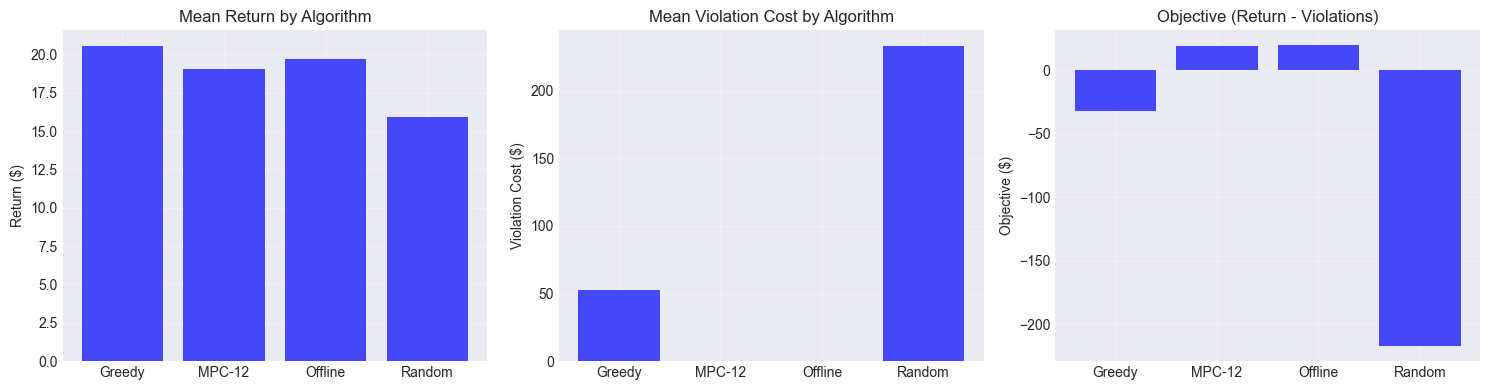

We report episode‑level mean return, mean violation cost, and the composite objective (return − violations). See Tutorial 03 for per‑step vs cumulative cost conventions.


In [10]:
# Use the interactive algorithm arena for synchronized comparison
# Note: Exclude Offline from the interactive arena because reusing the same
# OfflineOptimal instance after a full 288-step rollout causes its internal
# timestep to overflow on subsequent use. Keeping interactive to policies that
# don't require full-episode planning avoids this issue.
algorithms = {name: wrap_policy(algo) for name, algo in baseline_algos.items() if name != 'Offline'}

# Reuse the planning-friendly evaluation env config for the arena
env_fn = lambda: eval_env_fn()

arena = algorithm_arena(algorithms, env_fn, seed=42, max_steps=288,
                        metrics_to_track=['profit', 'carbon_cost', 'excess_charge'])
display(arena)

# Summarize baseline performance: reward vs violation cost (episode means)
try:
    if baseline_eval_rows:
        _df = pd.DataFrame(baseline_eval_rows)
        # Keep a stable ordering by algorithm name
        _df = _df.sort_values('algorithm')
        show("section: Reward vs Violation Cost (Episode Means)")
        quick_plot({
            'layout': '1x3',
            'size': (15, 4),
            'plots': [
                {
                    'type': 'bar',
                    'data': _df,
                    'x': 'algorithm',
                    'y': 'return_mean',
                    'title': 'Mean Return by Algorithm',
                    'ylabel': 'Return ($)'
                },
                {
                    'type': 'bar',
                    'data': _df,
                    'x': 'algorithm',
                    'y': 'violation_cost_mean',
                    'title': 'Mean Violation Cost by Algorithm',
                    'ylabel': 'Violation Cost ($)'
                },
                {
                    'type': 'bar',
                    'data': _df,
                    'x': 'algorithm',
                    'y': 'objective_mean',
                    'title': 'Objective (Return - Violations)',
                    'ylabel': 'Objective ($)'
                }
            ]
        }, {})
        show("text: We report episode‑level mean return, mean violation cost, and the composite objective (return − violations). This aligns with the cost definitions from Section 2.")
except Exception:
    pass

> For a full MPC deep dive, see `tutorials/08_ev_mpc_deep_dive.py`:
> - Why different MPC horizons perform similarly in this setting
> - How to create scenarios where horizons matter
> - Computational scaling, stability, and limitations
> - Complete investigations and debug scripts


## Section 3: Constraint and Safety Analysis

### 3.1 Constraint Slack Inspection

Network constraints limit total current flow. "Slack" is the safety margin before violating a constraint. Near-zero slack means the constraint is binding (limiting our actions).

**Insight:** Understanding when and where constraints bind helps identify infrastructure bottlenecks and guides policy design.

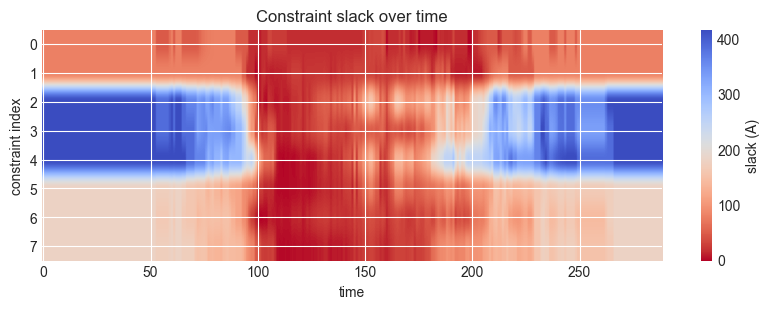

In [11]:
# Use utilities instead of reimplementing
show("progress: Running MPC-12 to populate simulator arrays...")
_ = rollout_baseline(env, mpc_12, seed=42)

# Use utility functions for constraint analysis
test_times = [24, 48, 96, 144, 192]  # Every 2 hours
show("header: Constraint Analysis at Key Times")

for T in test_times:
    if T < env.t - 1:
        # Use utility function instead of custom implementation
        mag, slack = constraint_slack_t(env, T)
        show("section: Time t={t} (hour {h:.1f})", t=T, h=T/12)
        show_metrics({'Min slack (A)': f"{np.min(slack):.2f}", 'Binding constraints': int(np.sum(slack < 5))})

# Use utility for constraint slack visualization
show("section: Constraint Slack Heatmap")
plot_slack_from_env(env)

# Get full constraint series for analysis
mags, slacks = constraint_slack_series(env)
show("section: Constraint statistics over episode")
show_metrics({'Min slack observed (A)': f"{np.min(slacks):.2f}", 'Timesteps with binding (slack<5)': int(np.sum(np.min(slacks, axis=1) < 5))})

### 3.2 Pilot Currents vs Slack: Complementary Views of Constraints

**What “pilot currents” are.** In J1772/EVSE terms, the “pilot” is the control signal from the charger to the EV that advertises the maximum allowable current. In ACN‑Sim, this becomes the commanded charging current per station (Amps) at each time step.

• These are the post‑constraint, post‑network values (what the simulator actually commanded), not just the raw policy action. They reflect capping, allocations, and network limits.

**Why this complements slack analysis.** Slack from `constraint_slack_series(env)` measures how far each network constraint is from binding: `slack = ampacity − |current|`. Near zero or negative slack means a constraint is at/over its limit.

• Pilot currents tell you where the load is actually being placed (which stations, how much, when). Slack tells you whether the network edges (transformer/lines) are near their ampacity.
• Combining them: low‑slack windows + which stations had high pilot currents shows the “who/when” behind binding pressure. Slack alone can’t identify stations; pilot currents alone don’t show proximity to violation.

Below we (1) plot a station‑by‑time heatmap of pilot currents with binding windows highlighted, and (2) summarize per‑station utilization. These directly complement the slack heatmap above.

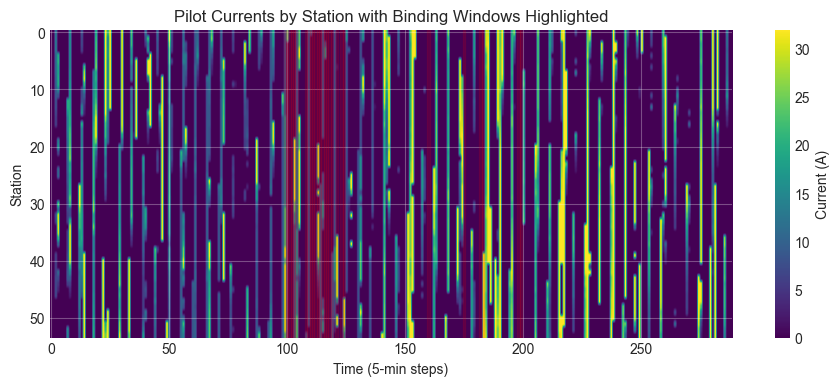

In [12]:
# Refresh rollout to populate simulator arrays using utility (standardized stepping)
_traj_tmp = collect_trajectory_direct(env, mpc_12, max_steps=288, seed=42, standardize=False)

# Tidy pilot signals
ps = pilot_signals_df(env)  # columns: ['t', 'station', 'amps']
if (ps is not None) and (not ps.empty) and (float(np.nan_to_num(ps['amps'].abs()).sum()) > 1e-9):
    # Reuse slack series computed above; fallback if not available in scope
    try:
        min_slack = np.min(slacks, axis=1)
    except Exception:
        _, _sl = constraint_slack_series(env)
        min_slack = np.min(_sl, axis=1)

    threshold = 5.0  # A margin threshold to mark tight/binding periods

    # Station-by-time matrix
    heat_df = ps.pivot(index='station', columns='t', values='amps').fillna(0)
    heat = heat_df.values
    T_heat = heat.shape[1] if heat.ndim == 2 else 0

    if T_heat > 0:
        # Render via quick_plot and overlay binding windows using annotations (no direct Axes handling)
        bind_positions = list(np.where((min_slack[:T_heat] < threshold))[0])
        annotations = [
            {
                'region': (int(t_idx) - 0.5, int(t_idx) + 0.5),
                'ymin': 0.0,
                'ymax': 1.0,
                'alpha': 0.12,
                'color': 'red',
            }
            for t_idx in bind_positions
        ]
        quick_plot({
            'type': 'heatmap',
            'data': heat,
            'cmap': 'viridis',
            'clabel': 'Current (A)',
            'figsize': (11, 4),
            'title': 'Pilot Currents by Station with Binding Windows Highlighted',
            'xlabel': 'Time (5-min steps)',
            'ylabel': 'Station',
            'annotations': annotations,
        }, {})
else:
    show("warning: No pilot signals recorded or all zeros; skipping pilot-current plots.")

### 3.3 Violation Analysis

When and how often each algorithm violates constraints. Violations incur penalties and could damage equipment in real deployments.

In [ ]:
# Cost signal conventions used in diagnostics below:
# - The environment reports a cumulative `info['reward_breakdown']['excess_charge']`.
# - When deriving per-step costs, we difference the cumulative series (see utilities).
# - Monetary units ($) are consistent with env constants (profit/carbon/cost factors).
# - See env source for constants; avoid overriding here to keep comparisons fair.
import numpy as np

# Build violation data directly (convert cumulative excess to per-step when monotonic)
# Note: env reports reward_breakdown['excess_charge'] as a COST in dollars per step.
#       We keep dollars here for consistency with profit/carbon_cost.
violation_data = []
for name, traj in trajectories.items():
    excess = np.array(traj['excess_charge'], dtype=float)
    step_costs = np.diff(np.r_[0.0, excess]) if np.all(np.diff(excess) >= -1e-9) else excess
    for t, cost in enumerate(step_costs):
        violation_data.append({'t': t, 'excess_charge': float(cost), 'run_id': name})

viol_df = pd.DataFrame(violation_data)
plot_violation_heatmap(viol_df)

# Summary statistics (cost units: $)
show("header: Violation Summary")
for name in trajectories.keys():
    v = np.asarray(trajectories[name]['excess_charge'], dtype=float)
    if v.size == 0:
        total_viol = 0.0
        viol_steps = 0
    else:
        # If series is cumulative (monotone nondecreasing), difference it; else assume per-step
        step_costs = np.diff(np.r_[0.0, v]) if np.all(np.diff(v) >= -1e-9) else v
        total_viol = float(np.sum(step_costs))
        viol_steps = int(np.sum(step_costs > 0))
    show("metric: {name:8s}: Violation cost = ${total:.2f} over {steps} steps", name=name, total=total_viol, steps=viol_steps)

### [Removed] Action Critique with One-Step MPC

[Removed in favor of focused MPC analysis in `08_ev_mpc_deep_dive.py`]

### 3.4 Deterministic State Reconstruction Helper

What we're doing: Reconstruct the environment state at timestep `t` deterministically by re-simulating from reset with a given policy. This makes counterfactual critiques and ablations reproducible and easier to read.

In [14]:
# Example usage: get state at t=144 under greedy rollout (utility)
obs_t144 = reconstruct_state(env, wrap_policy(greedy), t=144, seed=42)

Key messages:
- Use the same policy and seed to ensure deterministic reconstruction.
- Swap in different policies to compare "what-if" states at the same time index.


### 3.5 Critical State Ranking

**Purpose:** Identify the most challenging moments in the day where good decisions matter most. These are typically when demand is high, MOER is high, and constraints are tight.


#### How Critical Windows Are Identified

We identify critical windows by scoring each timestep based on a simple heuristic: a combination of high aggregate demand and high carbon intensity (MOER). Windows are then centered around the highest-scoring, non-overlapping moments.

**The key idea is simple:** periods where many cars need charging simultaneously, and when grid electricity is dirtiest, are the most challenging and important to get right. Our scoring function is a direct implementation of this intuition.


In [15]:
# Direct utility usage for critical windows (no wrapper)
traj_mpc_12 = trajectories['MPC-12']
demands = np.sum(np.stack(traj_mpc_12['demands']), axis=1)
critical_windows, _ = find_critical_windows_from_series(
    moer=traj_mpc_12['moer'][:len(demands)],
    agg_demand=demands,
    slack=None,
    topk=5,
    window=12,
)

show("section: Top 5 Critical Windows (MPC-12)")
for i, (start, end) in enumerate(critical_windows):
    show("metric: Rank {rank}: t=[{start},{end}) (hours {h1:.1f}-{h2:.1f})", 
         rank=i+1, start=start, end=end, h1=start/12, h2=end/12)

#### Interactive Critical Timeline (Targeted)


In [16]:
# Build a minimal trajectory dict for interactive timeline for MPC-12
traj = trajectories['MPC-12']

reward = np.array(traj['reward'], dtype=float)
action = np.stack(traj['action'])
obs_seq = []

# Re-run a short episode to collect obs for each step (lightweight)
_obs, _ = env.reset(seed=42)
obs_seq.append(_obs)
for t in range(1, len(reward)):
    a = mpc_12.get_action(_obs)
    _obs, _, done, _, _ = env.step(a)
    obs_seq.append(_obs)
    if done:
        break

# Convert cumulative excess_charge to per-step using differences if needed
cum_ec = np.array(traj['excess_charge'], dtype=float)
excess_step = np.diff(np.r_[0.0, cum_ec])

moer_series = np.array(traj['moer'][:len(reward)], dtype=float)

timeline = {
    'reward': reward,
    'action': action[:len(reward)],
    'obs': obs_seq[:len(reward)],
    'excess_charge': excess_step[:len(reward)],
    'moer': moer_series,
}

interactive_critical_timeline(timeline, env, wrap_policy(mpc_12))

    'data': [{'line': {'co…

Section 2 MPC horizon and forecast ablation content migrated to 08_ev_mpc_deep_dive.py

## 4. Robustness and Scenario Testing

**What we're testing:** Real-world deployments face two types of challenges:
1. **Measurement/control errors** - sensor noise, actuator imprecision, communication delays
2. **Operational variability** - different arrival patterns, demand spikes, unusual days

This comprehensive analysis tests both types to identify which algorithms are most robust and where they fail.

### 4.1 Noise Robustness

**Purpose:** Test how algorithms perform when observations or actions are corrupted by noise. This simulates real-world sensor errors (e.g., ±5% energy measurement error) and actuator imprecision (e.g., charging rate varies ±5% from commanded).

**Key insight:** MPC algorithms can replan when disturbances occur, making them more robust than purely reactive approaches. The heatmaps reveal performance degradation patterns.

In [ ]:
# Test robustness using utility functions
show("header: Noise Robustness Analysis for Baselines")

# Run sweeps for both algorithms first to compute a shared color scale
robustness_results = {}
for name, algo in [('Greedy', greedy), ('MPC-12', mpc_12)]:
    policy_fn = wrap_policy(algo)
    # Build a factory that forwards noise settings to env creation
    def make_env_fn(noise=None, noise_action=None):
        return create_ev_env(
            site='caltech',
            date_range=('2019-05-01', '2019-08-31'),
            seed=42,
            flatten=False,
            moer_forecast_steps=36,
            project_action_in_env=False,
            dense_mode=TUTORIAL_DENSE,
            density_multiplier=10.0,
            noise=noise,
            noise_action=noise_action,
        )

    df = sweep_noise(
        policy_fn, make_env_fn,
        Ns=[0.0, 0.05, 0.1, 0.2],
        N_as=[0.0, 0.05, 0.1],
        episodes=2
    )
    # Compute combined objective consistent with earlier sections: objective = return - violations
    df = df.copy()
    df['objective'] = df['return_mean'] - df['safety_cost']
    robustness_results[name] = df

# Determine shared color scale across algorithms (objective)
all_objectives = np.concatenate([robustness_results[k]['objective'].to_numpy() for k in robustness_results.keys()])
vmin_shared = float(np.nanmin(all_objectives)) if all_objectives.size else None
vmax_shared = float(np.nanmax(all_objectives)) if all_objectives.size else None

# Plot with consistent green-to-red colormap (red=low, green=high) and shared range
for name in ['Greedy', 'MPC-12']:
    show("section: {name} Robustness Test:", name=name)
    robustness_df = robustness_results[name]
    show("table", df=robustness_df)
    plot_robustness_heatmap(
        robustness_df,
        value='objective',
        title=f"{name} Robustness to Noise (Objective = Return - Violations)",
        cmap='RdYlGn',
        vmin=vmin_shared,
        vmax=vmax_shared,
    )
    # Performance degradation at a moderate noise point using objective
    def _obj_at(n, na):
        row = robustness_df[(robustness_df['noise'] == n) & (robustness_df['noise_action'] == na)]
        return float(row['objective'].values[0]) if len(row) > 0 else np.nan
    baseline_perf = _obj_at(0.0, 0.0)
    noisy_perf = _obj_at(0.1, 0.05)
    if np.isfinite(baseline_perf) and abs(baseline_perf) > 1e-9 and np.isfinite(noisy_perf):
        degradation = (baseline_perf - noisy_perf) / abs(baseline_perf) * 100.0
        show("metric: Performance degradation at moderate noise (objective): {deg:.1f}%", deg=degradation)
    else:
        show("warning: Could not compute degradation metric for {name}", name=name)

**Why this matters:** A policy that works well on average days might fail during unusual conditions (e.g., conference at campus, heat wave, grid emergency). Understanding failure modes helps design robust policies.

**Key Takeaways from Robustness Analysis**

1.  **Not All Algorithms Are Equally Robust:** Controllers with planning capabilities, like MPC, are inherently more robust to noise and disturbances because they can adapt and replan. Reactive policies are more brittle.
2.  **Identify Failure Modes:** Robustness testing is not about finding a single best algorithm, but about understanding the specific conditions under which each algorithm fails. This is crucial for safe deployment.
3.  **Guide for RL Development:** This analysis tells us where an advanced RL agent can provide the most value. An RL agent should, at a minimum, be as robust as the MPC baseline and ideally handle the corner cases where MPC fails.


### 4.3 Action Distribution Analysis

**What this shows:** The distribution of actions reveals algorithm behavior patterns:
- **Saturation at 0**: Station is idle (no EV or constraint prevents charging)
- **Saturation at 1**: Charging at maximum rate (greedy behavior or high demand)
- **Mid-range values**: Careful optimization balancing multiple objectives

The `plot_action_distribution()` utility provides comprehensive statistical analysis with a single function call.

In [ ]:
# Comprehensive action analysis using utilities
for name in ['Greedy', 'MPC-12', 'Offline']:
    traj = trajectories[name]
    actions = np.stack(traj['action'])

    show("section: {name} Action Analysis", name=name)

    # Use comprehensive utility function
    stats = plot_action_distribution(
        actions,
        title=f'{name} Action Distribution Analysis',
        show_stats=True,
        show_saturation=True,
        return_stats=True
    )

    # Key statistics in formatted form
    show_metrics({
        'Mean action': f"{stats['mean']:.3f}",
        'Saturation high': f"{stats['saturation_high']*100:.1f}%",
        'Saturation low': f"{stats['saturation_low']*100:.1f}%",
    })

## 5. Advanced Diagnostics and Results

### 5.1 Critical Moment Timeline

**What this visualization shows:** A synchronized view of all system variables with critical periods highlighted. This helps identify temporal patterns in system stress and understand the interplay between demand, carbon intensity, constraints, and EV arrivals.

**Why this matters:** System stress rarely comes from a single factor. Critical moments emerge from combinations: high demand + high MOER + tight constraints. This integrated view reveals these patterns and guides both operational strategies and infrastructure planning.

In [ ]:
def plot_critical_timeline():
    """
    Creates comprehensive timeline with critical events highlighted.
    Integrates multiple data streams to identify system stress patterns.
    """
    
    show("header: CRITICAL MOMENT TIMELINE ANALYSIS")
    
    # Use MPC-12 as reference (good balance of performance and feasibility)
    traj = trajectories['MPC-12']
    
    # Re-run to ensure we have fresh constraint data
    show("progress: Generating fresh constraint data...")
    _ = rollout_baseline(env, mpc_12, seed=42)
    
    # Get critical windows using utility function
    moer = traj['moer']
    agg_demand = np.sum(np.stack(traj['demands']), axis=1)
    
    # Get constraint slack data
    mags, slacks = constraint_slack_series(env)
    min_slack = np.min(slacks, axis=1) if len(slacks) > 0 else None
    
    # Align series lengths to avoid broadcasting issues (e.g., simulator may record T+1 steps)
    # Note: do not depend on 'active_evs' being present; derive it later if needed
    T_align = min(
        len(moer),
        len(agg_demand),
        len(min_slack) if min_slack is not None else len(moer),
        len(traj['action']),
        len(traj['reward']),
        len(traj['carbon_cost']),
        len(traj['excess_charge']),
    )
    moer_aligned = np.asarray(moer).reshape(-1)[:T_align]
    demand_aligned = np.asarray(agg_demand).reshape(-1)[:T_align]
    slack_aligned = np.asarray(min_slack).reshape(-1)[:T_align] if min_slack is not None else None
    
    # Find critical windows with composite scoring
    critical_windows, _ = find_critical_windows_from_series(
        moer=moer_aligned,
        agg_demand=demand_aligned,
        slack=slack_aligned,
        topk=10,
        window=6  # 30-minute windows
    )
    
    show("metric: Critical windows identified: {n}", n=len(critical_windows))
    
    # Build aligned time axis and dependent series
    time_hours = np.arange(T_align) / 12

    # Prepare demands/actions (aligned) for panel 1
    try:
        demands_arr = np.stack([np.asarray(d, dtype=float) for d in traj['demands']])
    except Exception:
        demands_arr = np.stack(traj['demands']).astype(float, copy=False)
    demand = np.sum(demands_arr, axis=1).astype(float)

    try:
        actions_arr = np.stack([np.asarray(a, dtype=float) for a in traj['action']])
    except Exception:
        actions_arr = np.stack(traj['action']).astype(float, copy=False)
    charging = np.mean(actions_arr, axis=1).astype(float) * float(getattr(env, 'ACTION_SCALE_FACTOR', 1.0))

    x_t = time_hours
    demand_t = demand_aligned
    charging_t = charging[:T_align]

    # EVs and arrivals (aligned) for panel 4
    # Derive active EV count if not present: count stations with positive demand
    if 'active_evs' in traj:
        evs_full = np.asarray(traj['active_evs'], dtype=float)
    else:
        try:
            demands_arr_for_evs = np.stack([np.asarray(d, dtype=float) for d in traj['demands']])
        except Exception:
            demands_arr_for_evs = np.stack(traj['demands']).astype(float, copy=False)
        evs_full = np.sum(demands_arr_for_evs > 1e-9, axis=1).astype(float)
    evs_aligned = evs_full[:T_align]
    arrivals = np.diff(evs_aligned, prepend=0)
    arrivals[arrivals < 0] = 0
    avg_evs = float(np.mean(evs_aligned))

    # Cumulative series for panel 5
    reward_aligned = np.asarray(traj['reward'], dtype=float)[:T_align]
    carbon_aligned = np.asarray(traj['carbon_cost'], dtype=float)[:T_align]
    viol_aligned = np.asarray(traj['excess_charge'], dtype=float)[:T_align]
    cum_reward = np.cumsum(reward_aligned)
    cum_carbon = np.cumsum(carbon_aligned)
    cum_violations = np.cumsum(viol_aligned)

    # Use aligned MOER for threshold computation
    moer_threshold = float(np.percentile(moer_aligned, 75))

    # Annotations: shaded critical windows for each panel
    ann_regions = [
        {'region': (start/12, end/12), 'alpha': 0.15, 'color': 'red'}
        for (start, end) in critical_windows
    ]

    # Dataset for quick_plot
    data = {
        'time': x_t,
        'demand_t': demand_t,
        'charging_t': charging_t,
        'moer_aligned': moer_aligned,
        'slack_aligned': (slack_aligned if slack_aligned is not None else np.zeros(T_align)),
        'evs_aligned': evs_aligned,
        'arrivals': arrivals,
        'cum_reward': cum_reward,
        'neg_cum_carbon': -cum_carbon,
        'neg_cum_violations': -cum_violations,
        'zeros': np.zeros(T_align),
    }

    # Build multi-panel spec leveraging notebook quick_plot utilities
    panels = []
    # Panel 1: Demand + Charging (twin y)
    panels.append({
        'type': 'line', 'x': 'time', 'y': 'demand_t', 'color': 'red', 'lw': 2,
        'title': 'Demand and Charging (Critical Windows Highlighted in Red)',
        'ylabel': 'Demand (kWh)', 'grid': True,
        'twin_y': {'type': 'line', 'x': 'time', 'y': 'charging_t', 'color': 'blue', 'alpha': 0.8, 'label': 'Avg Charging Rate (A)', 'ylabel': 'Charging (A)'},
        'annotations': ann_regions
    })
    # Panel 2: MOER with threshold line
    panels.append({
        'type': 'line', 'x': 'time', 'y': 'moer_aligned', 'color': 'green', 'lw': 2,
        'title': 'Carbon Intensity', 'ylabel': 'MOER\n(kg CO₂/kWh)', 'grid': True,
        'hline': {'y': moer_threshold, 'color': 'darkgreen', 'linestyle': '--', 'alpha': 0.5, 'label': f'75th percentile ({moer_threshold:.3f})'},
        'annotations': ann_regions,
        'legend': True
    })
    # Panel 3: Slack (or placeholder if not available)
    if slack_aligned is not None:
        panels.append({
            'type': 'line', 'x': 'time', 'y': 'slack_aligned', 'color': 'purple', 'lw': 2,
            'title': 'Constraint Slack (Safety Margin)', 'ylabel': 'Min Slack (A)', 'grid': True,
            'hline': [
                {'y': 0, 'color': 'red', 'linestyle': '-', 'lw': 2, 'label': 'Violation'},
                {'y': 5, 'color': 'orange', 'linestyle': '--', 'alpha': 0.7, 'label': 'Critical (5A)'},
                {'y': 10, 'color': 'yellow', 'linestyle': '--', 'alpha': 0.5, 'label': 'Warning (10A)'}
            ],
            'annotations': ann_regions,
            'ylim': (-5, 30),
            'legend': True
        })
    else:
        panels.append({
            'type': 'line', 'x': 'time', 'y': 'zeros', 'color': 'gray', 'lw': 1,
            'title': 'Constraint Slack (No data available)', 'ylabel': 'Min Slack (A)', 'grid': True,
            'annotations': ann_regions
        })
    # Panel 4: Active EVs + Arrivals (twin bar)
    panels.append({
        'type': 'line', 'x': 'time', 'y': 'evs_aligned', 'color': 'darkblue', 'lw': 2,
        'title': 'EV Population', 'ylabel': 'Active EVs', 'grid': True,
        'twin_y': {'type': 'bar', 'x': 'time', 'y': 'arrivals', 'color': 'cyan', 'alpha': 0.5, 'label': 'New Arrivals', 'ylabel': 'Arrivals', 'legend': True},
        'hline': {'y': avg_evs, 'color': 'darkblue', 'linestyle': ':', 'alpha': 0.5, 'label': f'Avg: {avg_evs:.0f}'},
        'annotations': ann_regions,
        'legend': True
    })
    # Panel 5: Cumulative curves
    panels.append({
        'type': 'line', 'x': 'time', 'y': 'cum_reward', 'color': 'black', 'lw': 2.5,
        'title': 'Cumulative Performance', 'xlabel': 'Time (hours)', 'ylabel': 'Cumulative Value ($)', 'grid': True,
        'overlay': [
            {'type': 'line', 'x': 'time', 'y': 'neg_cum_carbon', 'color': 'green', 'lw': 2, 'alpha': 0.7, 'label': 'Carbon Cost'},
            {'type': 'line', 'x': 'time', 'y': 'neg_cum_violations', 'color': 'red', 'lw': 2, 'alpha': 0.7, 'label': 'Violations'}
        ],
        'annotations': ann_regions,
        'legend': True
    })

    quick_plot({
        'layout': '5x1',
        'figsize': (15, 14),
        'sharex': True,
        'plots': panels,
        'title': 'System Timeline with Critical Periods (MPC-12)',
        'tight': True,
        'show': True
    }, data)
    
    # Detailed analysis of critical windows
    show("header: CRITICAL WINDOW DETAILED ANALYSIS")
    
    for i, (start, end) in enumerate(critical_windows[:5]):  # Top 5
        show("section: Critical Window {idx}: Hours {h1:.1f}-{h2:.1f}", idx=i+1, h1=start/12, h2=end/12)
        
        # Extract window statistics
        window_demand = demand_aligned[start:end]
        window_moer = moer_aligned[start:end]
        window_slack = slack_aligned[start:end] if slack_aligned is not None else None
        window_evs = evs_aligned[start:end]
        window_charging = charging_t[start:end]
        
        metrics = {
            'Duration (min)': f"{(end-start)*5}",
            'Demand (mean±std kWh)': f"{np.mean(window_demand):.1f} ± {np.std(window_demand):.1f}",
            'MOER (mean±std)': f"{np.mean(window_moer):.3f} ± {np.std(window_moer):.3f}",
            'Active EVs (mean±std)': f"{np.mean(window_evs):.0f} ± {np.std(window_evs):.1f}",
            'Avg charging (A)': f"{np.mean(window_charging):.1f}",
        }
        if window_slack is not None and len(window_slack) > 0:
            metrics.update({
                'Min slack (A)': f"{np.min(window_slack):.1f}",
                'Constraint stress': 'HIGH' if np.min(window_slack) < 5 else 'MODERATE',
            })
        show_metrics(metrics)
        
        # Identify primary stress factor
        factors = []
        if np.mean(window_demand) > np.percentile(demand_aligned, 75):
            factors.append("High demand")
        if np.mean(window_moer) > np.percentile(moer_aligned, 75):
            factors.append("High carbon")
        if window_slack is not None and np.min(window_slack) < 5:
            factors.append("Constraint binding")
        if np.mean(window_evs) > np.percentile(evs_aligned, 75):
            factors.append("Many EVs")
        
        show("text: Stress factors: {f}", f=(', '.join(factors) if factors else 'Multiple moderate factors'))
    
    # System-wide patterns
    show("header: TEMPORAL PATTERNS")
    
    # Find peak hours for different metrics (use aligned arrays)
    peak_demand_hour = np.argmax(demand_aligned) / 12
    peak_moer_hour = np.argmax(moer_aligned) / 12
    peak_evs_hour = np.argmax(evs_aligned) / 12
    if slack_aligned is not None:
        min_slack_hour = np.argmin(slack_aligned) / 12
    else:
        min_slack_hour = None
    
    show("section: Peak hours")
    show_metrics({
        'Highest demand': f"{peak_demand_hour:.1f}h",
        'Highest MOER': f"{peak_moer_hour:.1f}h",
        'Most EVs': f"{peak_evs_hour:.1f}h",
        **({'Tightest constraint': f"{min_slack_hour:.1f}h"} if min_slack_hour is not None else {})
    })
    
    # Check if peaks align (system stress)
    peak_hours = [peak_demand_hour, peak_moer_hour, peak_evs_hour]
    if min_slack_hour is not None:
        peak_hours.append(min_slack_hour)
    
    peak_spread = max(peak_hours) - min(peak_hours)
    if peak_spread < 2:
        show("text: ⚠️ PEAKS ALIGN: System experiences compounded stress")
        show("text: Recommendation: Implement pre-charging or load shifting")
    else:
        show("text: ✓ PEAKS DISTRIBUTED: Natural load balancing occurs")
        show("text: Opportunity: Leverage temporal diversity for optimization")

plot_critical_timeline()

**Key Insights from Timeline Analysis**

- **System stress is a composite effect:** Critical moments are rarely caused by a single factor. They emerge from the interplay of high demand, high carbon intensity, and tight infrastructure constraints.
- **Temporal misalignment creates opportunity:** The fact that demand peaks and carbon intensity peaks do not perfectly align is the fundamental reason why intelligent, forward-looking control is valuable. Shifting load from a high-carbon peak to a low-carbon off-peak is the primary way to reduce emissions.
- **Bottlenecks are predictable:** The analysis consistently highlights the morning rush (e.g., 8-10 AM) as a period of high stress, providing a clear target for operational planning and potential infrastructure upgrades.

### 5.2 Constraint Binding Patterns

**Deep dive purpose:** Infrastructure constraints are often the limiting factor in EV charging operations. This analysis identifies:
1. Which specific constraints bind most frequently (infrastructure bottlenecks)
2. When constraints bind (temporal patterns)
3. How binding correlates with demand and other factors
4. Differences in how algorithms handle constraints

**Why this matters for RL:** Understanding constraint patterns helps design:
- Safe exploration strategies that avoid violations
- Reward shaping that anticipates constraints
- Curriculum learning that gradually increases constraint difficulty
- Infrastructure recommendations for real deployments

In [ ]:
def analyze_constraint_binding_patterns():
    """Comprehensive analysis of constraint binding patterns."""
    
    show("header: CONSTRAINT BINDING PATTERN ANALYSIS")
    show("text: Identifying infrastructure limitations and algorithmic differences")
    
    binding_analysis = {}
    binding_data = []
    
    # Analyze each algorithm (fresh instance per analysis to avoid internal state issues)
    for name in ['Greedy', 'MPC-12', 'Offline']:
        show("progress: Analyzing {name}", name=name)
        
        # Re-run to get fresh constraint data with a fresh algorithm instance
        if name == 'Greedy':
            algo = GreedyAlgorithm(env)
        elif name == 'MPC-12':
            algo = MPC(env, lookahead=12)
        else:
            algo = OfflineOptimal(env)
        traj = rollout_baseline(env, algo, seed=42)
        
        # Get constraint slack using utilities
        mags, slacks = constraint_slack_series(env)
        
        if len(slacks) > 0:
            # Thresholds
            binding_threshold = 5.0
            critical_threshold = 2.0
            
            min_slacks = np.min(slacks, axis=1)
            
            # Per-constraint frequencies (needed for Panel 1)
            constraint_binding_freq = np.mean(slacks < binding_threshold, axis=0)
            
            # Store analysis
            binding_analysis[name] = {
                'slacks': slacks,
                'min_slacks': min_slacks,
                'binding_rate': np.mean(min_slacks < binding_threshold),
                'critical_rate': np.mean(min_slacks < critical_threshold),
                'violation_rate': np.mean(min_slacks < 0),
                'constraint_binding_freq': constraint_binding_freq,
                'traj': traj
            }
            
            # Collect data for DataFrame
            for t in range(len(min_slacks)):
                # Derive active EVs if not present
                if 'active_evs' in traj and t < len(traj['active_evs']):
                    active_evs_t = float(traj['active_evs'][t])
                else:
                    try:
                        dem_t = np.asarray(traj['demands'][t], dtype=float)
                        active_evs_t = float(np.sum(dem_t > 1e-9))
                    except Exception:
                        active_evs_t = 0.0

                binding_data.append({
                    'algorithm': name,
                    't': t,
                    'hour': t / 12,
                    'min_slack': min_slacks[t],
                    'binding': min_slacks[t] < binding_threshold,
                    'demand': np.sum(traj['demands'][t]) if t < len(traj['demands']) else 0,
                    'active_evs': active_evs_t
                })
    
    binding_df = pd.DataFrame(binding_data)
    
    # Determine number of constraints for plotting
    n_constraints = 0
    if binding_analysis:
        example = next(iter(binding_analysis.values()))
        n_constraints = example['slacks'].shape[1]
    
    # Prepare heatmap data for Panel 2 (algorithm × hour -> binding probability)
    algo_order = [n for n in ['Greedy', 'MPC-12', 'Offline'] if n in binding_analysis]
    hour_bins = np.arange(24)
    heat_df = binding_df.copy()
    heat_df['hour_bin'] = heat_df['hour'].astype(int)
    pvt = heat_df.groupby(['algorithm', 'hour_bin'])['binding'].mean().unstack(fill_value=0.0)
    pvt = pvt.reindex(index=algo_order, columns=hour_bins, fill_value=0.0)
    binding_heatmap = pvt.values

    # Create visualizations using quick_plot (4 panels, 2x2)
    color_map = {
        'Greedy': '#d62728',        # red
        'MPC-12': '#9ca3af',        # gray (neutral)
        'Offline': '#6b7280',       # darker gray (neutral)
    }
    plots_config = {
        'layout': '2x2',
        'figsize': (14, 9),
        'plots': [
            # Panel 1: Per-constraint binding frequency (colored per algorithm)
            {
                'type': 'bar_multi',
                'bars': [
                    {
                        'x': np.arange(n_constraints),
                        'y': binding_analysis[name]['constraint_binding_freq'] * 100,
                        'offset': i*0.28,
                        'width': 0.28,
                        'label': name,
                        'color': color_map.get(name, 'steelblue')
                    }
                    for i, name in enumerate(algo_order)
                ],
                'title': 'Which Constraints Bind Most?',
                'xlabel': 'Constraint Index',
                'ylabel': 'Binding Frequency (%)'
            },
            # Panel 2: Temporal binding heatmap (Algorithm × Hour)
            {
                'type': 'heatmap',
                'data': 'binding_heatmap',
                'cmap': 'YlOrRd',
                'clabel': 'Binding Probability',
                'vmin': 0.0,
                'vmax': 1.0,
                'xticklabels': 'hours',
                'yticklabels': 'algo_order',
                'xtickrot': 0,
                'title': 'When Do Constraints Bind? (Probability Heatmap)',
                'xlabel': 'Hour of Day',
                'ylabel': 'Algorithm'
            },
            # Panel 3: Slack distribution (with thresholds)
            {
                'type': 'hist',
                'data': {name: binding_analysis[name]['slacks'].flatten() 
                        for name in algo_order if name in binding_analysis},
                'bins': 50,
                'title': 'Slack Distribution',
                'xlabel': 'Slack (A)',
                'vline': [
                    {'x': 0, 'color': 'red', 'linestyle': '-', 'label': 'Violation'},
                    {'x': 2, 'color': 'orange', 'linestyle': '--', 'label': 'Critical'},
                    {'x': 5, 'color': 'yellow', 'linestyle': '--', 'label': 'Binding'}
                ]
            },
            # Panel 4: Demand vs Slack
            {
                'type': 'scatter',
                'data': binding_df,
                'x': 'demand',
                'y': 'min_slack',
                'hue': 'algorithm',
                'title': 'How Demand Affects Constraints',
                'xlabel': 'Aggregate Demand (kWh)',
                'ylabel': 'Min Slack (A)',
                'hline': [
                    {'y': 0, 'color': 'red', 'linestyle': '--'},
                    {'y': 5, 'color': 'orange', 'linestyle': '--'}
                ]
            },
        ]
    }
    
    # Render with notebook utility
    quick_plot({
        **plots_config,
        'tight': True,
        'show': True
    }, {
        'binding_df': binding_df,
        'binding_heatmap': binding_heatmap,
        'algo_order': algo_order,
        'hours': np.arange(binding_heatmap.shape[1]) if binding_heatmap.size else np.arange(0),
    })
    
    # Statistics summary
    show("header: CONSTRAINT BINDING STATISTICS")
    
    for name in ['Greedy', 'MPC-12', 'Offline']:
        if name not in binding_analysis:
            continue
        analysis = binding_analysis[name]
        show("section: {name} Algorithm", name=name)
        show_metrics({
            'Binding rate': f"{analysis['binding_rate']*100:.1f}% of timesteps",
            'Critical rate': f"{analysis['critical_rate']*100:.1f}%",
            'Violation rate': f"{analysis['violation_rate']*100:.1f}%",
            'Average min slack': f"{np.mean(analysis['min_slacks']):.2f} A",
            'Minimum slack': f"{np.min(analysis['min_slacks']):.2f} A"
        })
    
    # Infrastructure recommendations
    show("header: INFRASTRUCTURE RECOMMENDATIONS")
    
    if binding_analysis:
        all_binding_freqs = np.array([binding_analysis[name]['constraint_binding_freq'] 
                                      for name in ['Greedy', 'MPC-12', 'Offline'] if name in binding_analysis])
        if len(all_binding_freqs) > 0:
            avg_binding_freq = np.mean(all_binding_freqs, axis=0)
            problem_constraints = np.where(avg_binding_freq > 0.3)[0]
            
            if len(problem_constraints) > 0:
                show("text: Constraints requiring upgrade (>30% binding across algorithms):")
                for idx in problem_constraints:
                    show("metric: Constraint C{idx}: {freq:.1f}% average binding", 
                         idx=int(idx), freq=avg_binding_freq[idx]*100)
            else:
                show("text: No single constraint is critically limiting. System is well-balanced for current demand.")
        else:
            show("text: No constraint frequency data available.")
    else:
        show("text: No binding analysis available.")
    
    # Save results
    save_path = save_timeseries('constraint_binding_patterns', binding_df, kind='baselines')
    show("result: Analysis saved to: {p}", p=save_path)
    
    return binding_analysis

binding_analysis = analyze_constraint_binding_patterns()

### Key Diagnostic Takeaways for RL

This tutorial introduces several diagnostic concepts that are critical for developing and debugging RL agents in complex, constrained environments.

1.  **Establish Performance Baselines:** Before training an RL agent, always establish performance bounds using simple and expert controllers. The gap between a myopic **Greedy** policy and a clairvoyant **Offline Optimal** policy defines the space for improvement. A strong **MPC** controller provides a realistic and often difficult-to-beat benchmark that any sophisticated RL agent must outperform.

2.  **Identify Critical States:** Not all states are equally important. Critical windows—periods of high demand, high carbon intensity, or tight network constraints—are where a policy's intelligence truly matters. By identifying these states, you can focus analysis, guide exploration, and design more effective training curricula for your RL agent.

3.  **Analyze Constraint-Binding Behavior:** In safety-critical systems, it's not enough to be optimal; you must also be safe. Analyzing when and where network constraints are close to being violated (i.e., when "slack" is low) is fundamental. This is the first step toward building a safety-aware agent that can manage trade-offs between reward and constraint satisfaction.

4.  **Perform Counterfactual Action Analysis:** To understand if an agent's action was truly good, compare it to what an expert (like a one-step MPC) would have done in the exact same situation. This "action critique" provides a powerful, localized signal for credit assignment and can help diagnose systematic biases in an agent's policy, such as being too greedy or too conservative.

**Key insights from constraint binding analysis:**
- Infrastructure bottlenecks are clearly identified (constraints that bind >30% of time)
- Greedy binds constraints most frequently due to lack of planning
- MPC and Offline better anticipate and avoid constraint violations
- Peak binding occurs during predictable periods (morning/evening rush)
- Sustained binding periods indicate infrastructure inadequacy
- Specific capacity recommendations can be made for infrastructure upgrades

### 5.3 Results Persistence

**Critical step:** Save all results in a standardized format that other tutorials can load. This enables:
- Consistent baselines across experiments
- Reproducible research
- Easy comparison with RL agents in Tutorial 03

Using utility functions ensures all tutorials save data in compatible formats.

In [ ]:
# All saving now uses utility functions
show("header: Saving all baseline results")

cache_dir = get_cache_dir('baselines')

for name, traj in trajectories.items():
    tag = f"baseline_{name.lower().replace('-', '_')}"
    
    # Save timeseries data
    ts_df = traj_to_timeseries_df(traj, name)
    path = save_timeseries(tag, ts_df, kind='baselines')
    show("result: Saved {name} to {path}", name=name, path=path)
    
    # Save actions separately if needed for MARL comparison
    action_df = pd.DataFrame({
        't': np.repeat(np.arange(len(traj['action'])), env.num_stations),
        'station': np.tile(np.arange(env.num_stations), len(traj['action'])),
        'action': np.stack(traj['action']).reshape(-1)
    })
    
    action_path = os.path.join(cache_dir, f'{tag}_actions.csv.gz')
    save_df_gz(action_df, action_path)

show("result: All trajectories saved to {dir}", dir=cache_dir)

## Key Takeaways

- **Utility Integration Benefits**: By leveraging shared utilities, we've reduced boilerplate while maintaining functionality. This improves maintainability and ensures consistency across tutorials.

**What we did (and why it matters for RL)**
- `evaluate_policy()` + baseline rollouts: establishes performance and safety baselines that RL should match/exceed. The gap to `Offline` and `MPC-12` bounds your achievable improvements.
- Critical-state ranking via `find_critical_windows_from_series()`: surfaces the small set of timesteps that drive most return and cost. RL should prioritize experience in these states (prioritized replay, curricula, or targeted data collection).
- Integrated timeline `plot_critical_timeline()`: synchronizes demand, charging, MOER, slack, EV arrivals, and cumulative metrics to explain why stress emerges (e.g., high demand × high MOER × tight slack). This informs reward design and constraints.
- Constraint analysis `constraint_slack_series()` and `plot_slack_from_env()`: reveals when/where the network is near binding. This is crucial in a CMDP framing where safety costs (e.g., `excess_charge`) must be controlled.
- Behavior views (pilot signals, action saturation, per-station utilization): shows whether policies saturate, balance load, or shift in time. These expose policy biases and capacity bottlenecks.
- Local action critique `action_critique_with_one_step_mpc()`: isolates immediate, per-step suboptimality and attributes deltas to reward components (profit/carbon/violations). This helps with credit assignment and reward shaping.

**Why these diagnostics are informative for RL**
- **State criticality and exploration:** Most of the value (and risk) concentrates in a few windows. Sampling and exploration should upweight these. Practical knobs: prioritized replay keyed by `critical_windows`, curriculum starting from stress windows, or sampling schedules that mimic peak hours.
- **Credit assignment:** Immediate deltas from one-step MPC show if the agent is systematically myopic (e.g., charging during high MOER). If local deltas are small but cumulative returns lag, issues likely stem from longer-horizon planning or poor forecasting features.
- **Safety as a cost (CMDP view):** Treat `excess_charge` as a cost and track slack distributions. If RL outperforms on reward but violates constraints more than MPC, consider Lagrangian/constrained RL, safety critics, or action filters.
- **Forecasts and lookahead:** The `moer_forecast_steps` and MPC horizon experiments quantify the value of anticipation. RL should ingest forecast features; ablations can confirm if the policy is using them.
- **Action scaling and projection:** If actions saturate at bounds (or the environment projects them), learning signals may be distorted. Compare training/eval with `project_action_in_env` on vs off and monitor saturation statistics.
- **Bottlenecks and coordination:** Station-level utilization plus slack heatmaps identify structural constraints. For MARL, these guide shaping terms or coordination rewards to avoid local greediness.

**How to use this during RL training (Tutorial 03+)**
- Add callbacks that:
  - compute slack histograms and critical-window coverage per epoch;
  - log action saturation rates and per-station utilization;
  - evaluate on held-out stress windows discovered by `find_critical_windows_from_series()`;
  - run robustness sweeps (noise/perturbations) to monitor generalization.
- Always compare against `MPC-12` via `algorithm_arena()` and standardized `evaluate_policy()` metrics (return, carbon cost, violations/safety cost, satisfaction).
- If performance regresses, use the provided targeted debuggers: `debug_reward_scaling()` (reward accounting), `debug_constraint_violations()` (safety mechanics and projection), `debug_dense_mode()` (data density), `debug_critical_windows()` (data alignment).

**Reading the signs**
- When it’s working:
  - peaks are distributed (timeline), slack rarely hits critical thresholds, carbon-aligned load shifting occurs, and action saturation decreases over training.
- When it’s not:
  - peaks align across demand/MOER/EVs/slack, violations spike despite good returns, actions clip at bounds, or forecasts are ignored (no temporal shifting). Use the diagnostics above to localize the failure mode.

## What's Next

**Tutorial 03: Standard RL** — Train RL agents to match or exceed MPC performance; Focus learning on the critical states identified here; Use the robustness testing framework to evaluate learned policies


## Acknowledgments

This tutorial series builds on:
- **[SustainGym](https://chrisyeh96.github.io/sustaingym/)** ([Yeh et al., 2023](https://openreview.net/forum?id=vZ9tA3o3hr)) — Base environment and baseline algorithms
- **[ACN-Data/Sim](https://github.com/zach401/acnportal)** ([Lee et al., 2019](https://doi.org/10.1145/3307772.3331015)) — Real charging data
- **[CVXPY](https://www.cvxpy.org/)** ([Diamond & Boyd, 2016](https://doi.org/10.1109/MCS.2018.2813306)) — Convex optimization for MPC implementation

**Survey:** Jin, M. (2025). [RL Meets the Power Grid](https://jinming.tech/assets/pdfs/2025-fnt-safe-rl-power-grid-survey.pdf). *Foundations and Trends in Electric Energy Systems*.

**Note:** AI-assisted tools were used in developing these materials.

